# Training Patches Extraction (under construction)

The usual approach for training Convolutional Neural Networks (CNNs) consists of feeding a labelled training set. Usually medical images come with different sizes, so it is normal to extract patches of the same size to be used in the CNN training. In our example, our network deals with 2D images, but we try to convey 3D information by extracting 3-channel images just like a RGB image. The first channel corresponds to the slice immediately above the slice being segmented, the 2-channel corresponds to the slice being segmented and the 3-channel correspond to the slice immediately below the slice being segmented.

In this illustration we extract patches using the [Calgary-Campinas-347](http://miclab.fee.unicamp.br/tools) public dataset, which the brain labels were generated using the [silver-standard](https://arxiv.org/abs/1710.08354) approach.

In [14]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import nibabel as nib
import os
import glob
import sys
from sklearn.feature_extraction.image import extract_patches_2d
import random
import time

MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import ipt_utils
import cnn_utils

In [17]:
patch_size = (64,64) 
max_patches = 10 # number of patches per slice
nslices = 120 # number of slices
offset = 20 # Offset to get non-brain slices
t = 0.5 # STAPLE threshold for getting mask bounding-box

#Adapt the following 3 paths accordingly
orig_path = "/Users/robertosouza/Documents/CC359_NEW/Original"
staple_path = "/Users/robertosouza/Documents/CC359_NEW/STAPLE"
patches_path = "/Users/robertosouza/Documents/Patches-CC347"


cc347_list =np.genfromtxt("../Data/cc347_orig.txt", dtype ="string")
cc347_staple = np.genfromtxt("../Data/cc347_staple.txt",dtype = "string")
print cc347_list[0]
print cc347_staple[0]

CC0001_philips_15_55_M.nii.gz
CC0001_philips_15_55_M_staple.nii.gz


In [18]:
for (orig,staple_auto) in zip(cc347_list,cc347_staple):
    # Initializing arrays to store the image and label patches
    patches_orig = np.zeros((nslices*max_patches,patch_size[0],patch_size[1],3))
    patches_staple_auto = np.zeros((nslices*max_patches,patch_size[0],patch_size[1]))
    
    # Loading original volume
    orig_data = os.path.join(orig_path,orig)
    orig_data = nib.load(orig_data).get_data()
    
    #Data normalization
    orig_min = orig_data.min()
    orig_max = orig_data.max()
    orig_data = 1000.0*(orig_data - orig_min)/(orig_max-orig_min)
    orig_data = orig_data.astype(np.uint16) # we save as uint16 to save space
        
    #Loading STAPLE mask
    staple_auto = os.path.join(staple_path,staple_auto)
    staple_auto = (nib.load(staple_auto).get_data())
    
    # Get bounding-box of the mask
    H,W,Z = orig_data.shape
    xmin,xmax,ymin,ymax,zmin,zmax = ipt_utils.crop3D(staple_auto > t)
    
    
    # Offsets the bounding-box to get non-brain samples
    xmin,xmax = np.maximum(xmin-offset,0),np.minimum(xmax+offset,H)
    ymin,ymax = np.maximum(ymin-offset,0),np.minimum(ymax+offset,W)
    zmin,zmax = np.maximum(zmin-offset,0),np.minimum(zmax+offset,Z)
    
    # crop volumes
    orig_data = orig_data[xmin:xmax,ymin:ymax,zmin:zmax]
    staple_auto = staple_auto[xmin:xmax,ymin:ymax,zmin:zmax]
    
    H2,W2,Z2 = orig_data.shape
    random.seed(time.time())
    np.random.seed(int(time.time()))
    counter = 0
    for ii in random.sample(range(1, W2-1), nslices):
        aux_orig = orig_data[:,ii-1:ii+2,:]
        staple_man_auto = staple_auto[:,ii,:]
        
        # Random seed for patch extraction
        rs = np.random.randint(0,1001)
        
            
        patches_orig_aux1 = extract_patches_2d(aux_orig[:,0,:],\
                            patch_size,max_patches,random_state = rs)
        patches_orig_aux2 = extract_patches_2d(aux_orig[:,1,:],\
                            patch_size,max_patches,random_state = rs)
        patches_orig_aux3 = extract_patches_2d(aux_orig[:,2,:],\
                            patch_size,max_patches,random_state = rs)
            
        patches_orig_aux = np.concatenate((patches_orig_aux1[:,:,:,np.newaxis],\
                                           patches_orig_aux2[:,:,:,np.newaxis],
                                           patches_orig_aux3[:,:,:,np.newaxis]),axis = -1)
            
        patch_auto_aux_staple = extract_patches_2d(staple_man_auto,patch_size,max_patches,random_state = rs)
        
        patches_orig[counter*max_patches:(counter+1)*max_patches] = patches_orig_aux
        patches_staple_auto[counter*max_patches:(counter+1)*max_patches] = patch_auto_aux_staple
        counter+=1
        
    file_name = orig.split("/")[-1].split(".")[0]
    
    #save patches
    np.save(os.path.join(patches_path,file_name+"_orig.npy"),patches_orig)
    np.save(os.path.join(patches_path,file_name+"_staple.npy"),patches_staple_auto)
    
    print file_name
    print patches_orig.shape
    print patches_staple_auto.shape

CC0001_philips_15_55_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0002_philips_15_56_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0005_philips_15_62_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0006_philips_15_63_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0007_philips_15_62_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0008_philips_15_60_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0009_philips_15_69_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0010_philips_15_69_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0011_philips_15_49_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0012_philips_15_43_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0013_philips_15_66_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0014_philips_15_62_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0015_philips_15_44_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0016_philips_15_55_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0017_philips_15_50_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0018_philips_15_41_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0019_philips_15_57_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0020_philips_15_65_F
(1200, 64, 64, 3)
(1200, 

CC0155_siemens_15_57_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0156_siemens_15_55_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0157_siemens_15_54_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0158_siemens_15_53_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0159_siemens_15_54_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0160_siemens_15_57_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0161_siemens_15_55_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0162_siemens_15_39_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0163_siemens_15_64_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0164_siemens_15_54_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0165_siemens_15_44_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0166_siemens_15_39_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0167_siemens_15_55_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0168_siemens_15_38_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0169_siemens_15_44_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0170_siemens_15_55_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0171_siemens_15_51_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0172_siemens_15_52_M
(1200, 64, 64, 3)
(1200, 

CC0315_ge_3_59_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0316_ge_3_57_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0317_ge_3_45_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0318_ge_3_52_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0319_ge_3_45_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0320_ge_3_57_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0321_ge_3_51_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0322_ge_3_59_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0323_ge_3_56_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0324_ge_3_56_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0325_ge_3_55_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0326_ge_3_55_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0327_ge_3_50_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0328_ge_3_56_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0329_ge_3_58_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0330_ge_3_57_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0331_ge_3_61_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0332_ge_3_53_F
(1200, 64, 64, 3)
(1200, 64, 64)
CC0333_ge_3_41_M
(1200, 64, 64, 3)
(1200, 64, 64)
CC0334_ge_3_45_M
(1200, 64, 64, 3)
(1200, 64, 64)


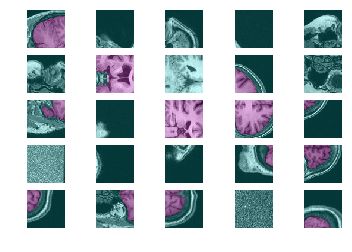

In [33]:
fig, ax = plt.subplots(nrows=5, ncols=5)
counter = 0
indexes = np.random.choice(patches_orig.shape[0],25,replace= False)
for row in ax:
    for col in row:
        col.imshow(patches_orig[indexes[counter],:,:,1], cmap = 'gray')
        col.imshow(patches_staple_auto[indexes[counter],:,:]>0.5, cmap = 'cool',alpha = 0.2)
        col.axis("off")
        counter+=1
plt.show()